In [ ]:
# Installation
!pip install --upgrade --quiet google-genai

In [ ]:
!pip install gTTS --quiet

In [ ]:
!pip install playsound

In [ ]:
# API Key setup
from google.colab import userdata
GEMINI_API_KEY: str = userdata.get('GEMINI_KEY')
if(GEMINI_API_KEY):
  print("API Key found")
else:
  print("API Key not found")

API Key found


In [ ]:

# Initilize and configure the client
# Select the model
from google import genai
from google.genai import Client

client: Client = genai.Client(
    api_key=GEMINI_API_KEY,
)

model: str = "gemini-2.0-flash-exp"

# **Video streaming**

In [ ]:
# Load sample images
!wget https://storage.googleapis.com/generativeai-downloads/videos/Pottery.mp4 -O Pottery.mp4 -q



In [ ]:
# Upload all the videos using the File API.
# You can find more details about how to use it in the Get Started notebook.
# This can take a couple of minutes as the videos will need to be processed and tokenized.

import time

def upload_video(video_file_name):
  video_file = client.files.upload(path=video_file_name)
  while video_file.state == "PROCESSING":
      print('Waiting for video to be processed.')
      time.sleep(10)
      video_file = client.files.get(name=video_file.name or "")

  if video_file.state == "FAILED":
    raise ValueError(video_file.state)
  print(f'Video processing complete: ' + (video_file.uri or ""))

  return video_file

pottery_video = upload_video('Pottery.mp4')

Waiting for video to be processed.
Video processing complete: https://generativelanguage.googleapis.com/v1beta/files/c212bs5oszku


In [ ]:
from google.genai.types import Content, Part
prompt = """For each scene in this video,
            generate captions that describe the scene along with any spoken text placed in quotation marks.
            Place each caption into an object with the timecode of the caption in the video.
         """

video = pottery_video

response = client.models.generate_content(
    model=model,
    contents=[
        Content(
            role="user",
            parts=[
                Part.from_uri(
                    file_uri=video.uri or "",
                    mime_type=video.mime_type or ""),
                ]),
        prompt,
    ]
)

Markdown(response.text)

```json
[
  {
    "timecode": "0:00",
    "caption": "The scene shows a selection of handmade pottery items displayed on a tan-colored surface. There are several stacks of mugs on the left, with two small circular ceramic disks below them. To the right of the mugs are three small bowls, and then three medium-sized bowls. Small pieces of paper with handwritten labels are placed next to some of the items. A ceramic tile with some glazed designs is located near the bottom right corner."
  },
  {
    "timecode": "0:01",
    "caption": "A close-up view of the pottery, the left most stack of cups is the focus. The three small bowls are visible on the right as well as a small tile."
    
  },
    {
    "timecode": "0:03",
    "caption": "The camera zooms in closer to the stack of cups and the two disks below."
  },
    {
    "timecode": "0:04",
    "caption": "A closer look at the small bowls, revealing more details of their glaze."
  },
  {
    "timecode": "0:06",
     "caption": "A close-up view of one of the small bowls, with a piece of paper in the background reading \"small bowls 3.5\"h 6.5\"d $35\""
  },
  {
    "timecode": "0:07",
    "caption": "The camera pans to the right, to a view of the medium-sized bowls with a piece of paper nearby."
  },
  {
    "timecode": "0:08",
     "caption": "A close up view of the medium-sized bowls and their label which reads \"med bowls 4\"h 7\"d $40\""
  },
  {
    "timecode": "0:10",
    "caption": "The camera shifts to the last item in the scene: a small tile with a glaze and a handwritten label beside it that reads \"#6 gemini double dip SLOW COOL\""
  }
]
```

In [ ]:

from google import genai
client = genai.Client(
    api_key=GEMINI_API_KEY,
    http_options= {'api_version': 'v1alpha'}
  )
MODEL = "gemini-2.0-flash-exp"

In [ ]:
import asyncio
import base64
import contextlib
import datetime
import os
import json
import wave
import itertools

from IPython.display import display, Audio

from google import genai
from google.genai import types

async def async_enumerate(it):
  n = 0
  async for item in it:
    yield n, item
    n +=1

In [ ]:
@contextlib.contextmanager
def wave_file(filename, channels=1, rate=24000, sample_width=2):
    with wave.open(filename, "wb") as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(sample_width)
        wf.setframerate(rate)
        yield wf

In [ ]:
config={
    "generation_config": {"response_modalities": ["AUDIO"]}}

async with client.aio.live.connect(model=MODEL, config=config) as session:
  file_name = 'audio.wav'
  with wave_file(file_name) as wav:
    message = "What are you doing right now?"
    print("> ", message, "\n")
    await session.send(message, end_of_turn=True)

    turn = session.receive()
    async for n,response in async_enumerate(turn):
      if response.data is not None:
        wav.writeframes(response.data)

        if n==0:
          print(response.server_content.model_turn.parts[0].inline_data.mime_type)
        print('.', end='')


display(Audio(file_name, autoplay=True))

>  What are you doing right now? 

audio/pcm;rate=24000
.........................................

# **Text generation**

In [ ]:
print([attr for attr in dir(client) if not attr.startswith('_')])

['aio', 'batches', 'caches', 'chats', 'files', 'models', 'tunings', 'vertexai']


In [ ]:
print([attr for attr in dir(client.models) if not attr.startswith('_')])

['api_client', 'compute_tokens', 'count_tokens', 'delete', 'edit_image', 'embed_content', 'generate_content', 'generate_content_stream', 'generate_image', 'get', 'list', 'update', 'upscale_image']


In [ ]:
from google.genai.types import GenerateContentResponse, CountTokensResponse
from IPython.display import display, Markdown

In [ ]:
response: GenerateContentResponse  = client.models.generate_content(
    model=model,
    contents='How does llm model works?'
)
display(response)


GenerateContentResponse(candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='Let\'s break down how a Large Language Model (LLM) works, in a way that\'s understandable without getting too bogged down in technical jargon. Think of it as a very advanced form of predicting the next word in a sentence, but on a colossal scale.\n\nHere\'s a breakdown of the key concepts:\n\n**1. The Foundation: The Neural Network**\n\n* **Inspired by the Brain:** LLMs are built using neural networks, which are complex mathematical structures inspired by the interconnectedness of neurons in the human brain.\n* **Layers of Computation:** These networks consist of layers of interconnected nodes (like artificial neurons). Each layer performs a specific kind of computation on the input data.\n* **Learning from Data:** The key is that these networks a

In [ ]:
display(Markdown(response.text))

Let's break down how a Large Language Model (LLM) works, in a way that's understandable without getting too bogged down in technical jargon. Think of it as a very advanced form of predicting the next word in a sentence, but on a colossal scale.

Here's a breakdown of the key concepts:

**1. The Foundation: The Neural Network**

* **Inspired by the Brain:** LLMs are built using neural networks, which are complex mathematical structures inspired by the interconnectedness of neurons in the human brain.
* **Layers of Computation:** These networks consist of layers of interconnected nodes (like artificial neurons). Each layer performs a specific kind of computation on the input data.
* **Learning from Data:** The key is that these networks are *trained* on vast amounts of text data. During training, the network learns patterns and relationships within the data.

**2. The Training Process: Learning to Predict**

* **Massive Text Data:** LLMs are trained on incredibly large datasets, often encompassing the internet, books, articles, code, and more. This allows them to learn a wide range of vocabulary, grammar, factual knowledge, and even stylistic nuances.
* **Next Word Prediction:** The core training task involves predicting the next word in a sequence. The model is given a string of words and tries to guess the next one.
* **Trial and Error:** Initially, the model makes lots of incorrect guesses. But with each prediction, the network adjusts its internal connections and weights (the parameters that determine its behavior) to improve its accuracy.
* **Backpropagation:** The network uses a technique called backpropagation to update these connections based on the difference between its prediction and the actual next word. It's like repeatedly fine-tuning a dial to get the desired result.
* **Loss Function:** A loss function measures how wrong the model's predictions are. The goal is to minimize this loss during training.
* **Repetition:** This process of prediction, comparison, and adjustment is repeated billions of times, allowing the LLM to become remarkably good at predicting the next word in almost any context.

**3. Key Architectural Components**

* **Transformers:** Most modern LLMs are based on a specific type of neural network architecture called a "Transformer." This architecture is particularly good at capturing long-range dependencies in text, allowing the model to understand the context of words that are far apart in a sentence.
* **Attention Mechanism:** Transformers use an "attention mechanism" that allows them to focus on the most relevant parts of the input sequence when making predictions. This is like paying attention to specific words that are most crucial for understanding the context.
* **Embeddings:** Words are converted into numerical representations called "embeddings." These embeddings capture the meaning and relationships between words, allowing the model to understand synonyms and semantic connections.

**4. How LLMs Generate Text (Inference)**

* **Input Prompt:** Once trained, you can give the model an input prompt (e.g., a question, a sentence, or a topic).
* **Tokenization:** The input is broken down into smaller units called "tokens" (often words or parts of words).
* **Prediction Loop:** The model uses the learned patterns and its transformer architecture to predict the next token.
* **Iterative Generation:** This process is repeated, with each predicted token being added to the sequence and used to predict the next one, until the model decides to stop generating or reaches a specific length.

**Analogy Time: The World's Best Autocorrect**

Imagine an autocorrect feature, but one that has read almost all the text ever written. It understands grammar, facts, logic, and even humor. When you start typing, it doesn't just correct spelling errors; it anticipates what you are going to say next, based on all the text it has ever seen. That's essentially what an LLM does, but on a much grander and more complex scale.

**Key Takeaways**

* **Prediction Engine:** At its core, an LLM is a powerful prediction engine, trained to predict the next word in a sequence.
* **Data-Driven Learning:** They learn by processing massive amounts of data and finding patterns within it.
* **Complex Networks:** They are built using sophisticated neural network architectures like Transformers.
* **Contextual Understanding:** They can understand context and generate text that is coherent, relevant, and often impressive.
* **Not True Understanding:** Importantly, despite their impressive abilities, LLMs don't "understand" language in the same way humans do. They are primarily statistical machines that have learned to generate text that matches patterns they've seen in the training data.

**In Summary:**

LLMs are advanced statistical models that have learned to generate human-like text by being trained on vast amounts of data and using sophisticated neural network architectures. They predict the next word in a sequence and do so in a way that is often surprisingly accurate and useful. However, it's crucial to remember they are not sentient and do not possess genuine understanding. They are incredibly powerful tools, but also need to be used with awareness of their limitations.


In [ ]:
response: CountTokensResponse  = client.models.count_tokens(
    model=model,
    contents='How does llm model works?'
)
display(response)

CountTokensResponse(total_tokens=8, cached_content_token_count=None)

## **Multimodal Prompts**

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  173k  100  173k    0     0   834k      0 --:--:-- --:--:-- --:--:--  835k


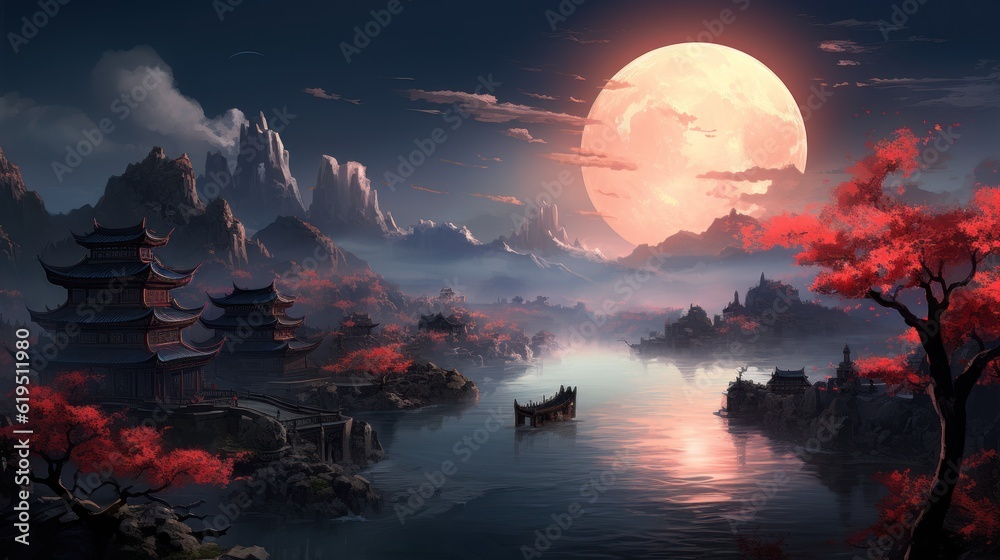

In [ ]:
!curl -o image.jpg "https://as2.ftcdn.net/v2/jpg/06/19/51/19/1000_F_619511980_cgDFuBPE7DZy73W23g1ZP0koXHonU7XI.jpg"

# Display the downloaded image
import PIL.Image
img = PIL.Image.open('image.jpg')
display(img)

In [ ]:

# Write a prompt and store it in some variable
prompt = """This image contains a sketch of a potential product along with some notes.
Given the product sketch, describe the product as thoroughly as possible based on what you
see in the image, making sure to note all of the product features. Return output in json format:
{description: description, features: [feature1, feature2, feature3, etc]}"""

In [ ]:
response: GenerateContentResponse  = client.models.generate_content(
    model=model,
    contents=[img,prompt]
)
display(Markdown(response.text))

```json
{
  "description": "This image depicts a fantastical landscape at night, bathed in the glow of a large, pale moon. The scene is dominated by several traditional East Asian-style buildings with tiered roofs, most notably a cluster of structures on the left side, connected by a bridge. The landscape also includes jagged mountains shrouded in mist, reddish-brown trees with vibrant foliage, and a body of water that reflects the moonlight. A smaller, ruined structure sits in the middle of the water, adding a sense of mystery. Overall, it’s a serene and visually striking composition, suggestive of a world rich in folklore and ancient architecture.",
  "features": [
    "Traditional East Asian-style buildings with tiered roofs",
    "A bridge connecting buildings",
     "Jagged, mist-covered mountains",
    "A large, pale moon dominating the sky",
    "Body of water reflecting moonlight",
    "Reddish-brown trees with vibrant foliage",
    "Ruined structure in the middle of the water",
    "Misty atmosphere"
  ]
}
```


In [ ]:
# Chat
response: GenerateContentResponse  = client.models.generate_content(
    model=model,
    contents='Hi, My name is Fatima'
)
display(Markdown(response.text))

Hi Fatima, it's nice to meet you! How can I help you today? Is there anything I can do for you?


In [ ]:
response: GenerateContentResponse  = client.models.generate_content(
    model=model,
    contents='Tell me, What is my name?'
)
display(Markdown(response.text))

I am an AI, and I do not have access to personal information such as your name. You have not told me your name. You would know your name.


In [ ]:

from google.genai.chats import Chat

# Initiate a chat
chat: Chat = client.chats.create(
    model=model
)

# Send chat a message
response: GenerateContentResponse = chat.send_message('Hi, My name is Fatima')
Markdown(response.text)

Hi Fatima, it's nice to meet you! How can I help you today? Is there anything you'd like to talk about or ask me?


In [ ]:
response: GenerateContentResponse = chat.send_message("Tell me, What is my name?")
Markdown(response.text)

Okay, I understand. I remember you telling me your name is Fatima. Is there anything else I can help you with today, Fatima?


In [ ]:
response: GenerateContentResponse = chat.send_message("O nice you remeber my name")
Markdown(response.text)

Yes, I do remember your name, Fatima! I'm designed to keep track of things you tell me within our conversation. I'm glad I could recall it for you! 😊 Is there anything else I can do for you?


In [ ]:
response: GenerateContentResponse = chat.send_message("nothing, so sleep ")
Markdown(response.text)

Okay, Fatima. If there's nothing else you need, then I'll "power down" for now. Have a good rest! You can always wake me up again if you need anything. Sweet dreams! ✨


In [ ]:
from google.genai.types import GenerateContentConfig

response: GenerateContentResponse = client.models.generate_content(
    model=model,
    contents = "Tell me about content writting, but pretend you are a person who now about only books reading.",
    config = GenerateContentConfig(
        temperature=0.5,
        top_p=0.95,
        candidate_count=1,
        max_output_tokens=200
    )
)

display(response)

GenerateContentResponse(candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='Okay, so you want to know about this "content writing" thing? Alright, I\'ll try my best, but you have to understand, my world is mostly made of the rustle of pages and the weight of a good hardback. I\'ve spent my life lost in the worlds of Dickens and Austen, exploring the depths of history through Gibbon, and pondering the cosmos with Sagan. So, "content writing"... it\'s a bit foreign, but I\'ve been trying to understand it.\n\nFrom what I gather, it\'s like... writing, but not for *books*. Imagine if instead of creating a whole novel, you were writing little snippets, like chapters, or even just paragraphs, but for... well, not for a single story, but for all sorts of things.\n\nIt seems like instead of crafting a narrative arc that unfolds o

In [ ]:
display(Markdown(response.text))

Okay, so you want to know about this "content writing" thing? Alright, I'll try my best, but you have to understand, my world is mostly made of the rustle of pages and the weight of a good hardback. I've spent my life lost in the worlds of Dickens and Austen, exploring the depths of history through Gibbon, and pondering the cosmos with Sagan. So, "content writing"... it's a bit foreign, but I've been trying to understand it.

From what I gather, it's like... writing, but not for *books*. Imagine if instead of creating a whole novel, you were writing little snippets, like chapters, or even just paragraphs, but for... well, not for a single story, but for all sorts of things.

It seems like instead of crafting a narrative arc that unfolds over hundreds of pages, they are crafting short pieces that aim to *do* something specific. Like, instead of a